In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
pd.set_option('display.max_columns', None)
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, make_scorer
import xgboost as xgb
import pickle

In [2]:
#import data and define test and train datasets
test = pd.read_pickle('test.pkl')
train = pd.read_pickle('train.pkl')

selected_features1 = train.loc[:,"exchange_NASDAQ":"location_Wisconsin; U.S.A"]
selected_features2 = train.loc[:, "ncfbus_abs":"ncfo_io"]
selected_features3 = train.loc[:, ["assets", "capex", "liabilities", "debtusd", "ebitdausd", "netinccmnusd", 
                                  "equityusd", "revenueusd", "cashnequsd", "marketcap", "ev"]]
selected_features_j = selected_features1.join(selected_features2)
selected_features = selected_features_j.join(selected_features3)

X_train = selected_features
y_train = train["firm"]

selected_features1 = test.loc[:,"exchange_NASDAQ":"location_Wisconsin; U.S.A"]
selected_features2 = test.loc[:, "ncfbus_abs":"ncfo_io"]
selected_features3 = test.loc[:, ["assets", "capex", "liabilities", "debtusd", "ebitdausd", "netinccmnusd", 
                                  "equityusd", "revenueusd", "cashnequsd", "marketcap", "ev"]]
selected_features_j = selected_features1.join(selected_features2)
selected_features = selected_features_j.join(selected_features3)

X_test = selected_features
y_test = test["firm"]

In [3]:
#scale data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
# load pre-trained/tuned models

model_names = ["decisiontree", "knn", "randomforest", "logistic", "xgboost"]

for model_name in model_names:
    with open(f"{model_name}.pkl", "rb") as pfile:
        exec(f"{model_name} = pickle.load(pfile)")

model_vars = [eval(n) for n in model_names]
model_list = list(zip(model_names, model_vars))

In [5]:
#view scores
for model_name in model_names:
    curr_model = eval(model_name)
    print(f'{model_name} score: {curr_model.score(X_test, y_test)}')

decisiontree score: 0.8694516971279374
knn score: 0.6710182767624021
randomforest score: 0.8838120104438643
logistic score: 0.7963446475195822
xgboost score: 0.8798955613577023


In [6]:
#fit voting classifier model - hard
voting_classifer_hard = VotingClassifier(estimators=model_list,
                                    voting='hard', 
                                    n_jobs=-1)
voting_classifer_hard.fit(X_train, y_train)
print(np.average(cross_val_score(voting_classifer_hard, X_train, y_train, cv=5)))

0.8591503267973856


In [7]:
#view accuracy score
y_pred = voting_classifer_hard.predict(X_test)
accuracy_score(y_test, y_pred)

0.8759791122715405

In [8]:
#view classification report
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print(result1)

Classification Report:
              precision    recall  f1-score   support

       Big 4       0.87      0.94      0.90       463
       Other       0.89      0.78      0.83       303

    accuracy                           0.88       766
   macro avg       0.88      0.86      0.87       766
weighted avg       0.88      0.88      0.87       766



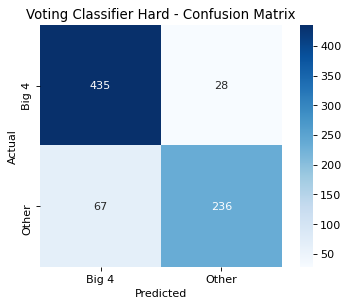

In [9]:
#view confusion matrix
confusion = confusion_matrix(y_test, y_pred)
plt.figure(dpi=80)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
           xticklabels=['Big 4', 'Other'],
           yticklabels=['Big 4', 'Other'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Voting Classifier Hard - Confusion Matrix');

In [11]:
filename = 'voting_classifier_hard.pkl'
pickle.dump(voting_classifer_hard, open(filename, 'wb'))

In [12]:
#fit voting classifier model - soft
voting_classifer_soft = VotingClassifier(estimators=model_list,
                                    voting='soft', 
                                    n_jobs=-1)
voting_classifer_soft.fit(X_train, y_train)
voting_classifer_soft.score(X_train, y_train)
print(np.average(cross_val_score(voting_classifer_soft, X_train, y_train, cv=5)))

0.8565359477124183


In [13]:
#view accuracy score
y_pred = voting_classifer_soft.predict(X_test)
accuracy_score(y_test, y_pred)

0.8746736292428199

In [14]:
#view classification report
result1 = classification_report(y_test, y_pred)
print("Classification Report:",)
print(result1)

Classification Report:
              precision    recall  f1-score   support

       Big 4       0.86      0.94      0.90       463
       Other       0.90      0.77      0.83       303

    accuracy                           0.87       766
   macro avg       0.88      0.86      0.87       766
weighted avg       0.88      0.87      0.87       766



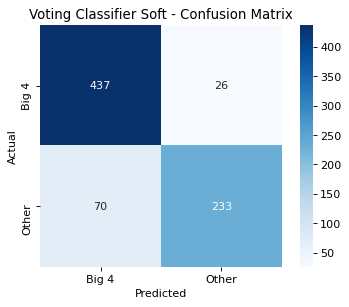

In [15]:
#view confusion matrix
confusion = confusion_matrix(y_test, y_pred)
plt.figure(dpi=80)
sns.heatmap(confusion, cmap=plt.cm.Blues, annot=True, square=True, fmt='g',
           xticklabels=['Big 4', 'Other'],
           yticklabels=['Big 4', 'Other'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Voting Classifier Soft - Confusion Matrix');

In [16]:
filename = 'voting_classifier_soft.pkl'
pickle.dump(voting_classifer_soft, open(filename, 'wb'))